<a href="https://colab.research.google.com/github/RD191295/Pytorch-Tutorials/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch WorkFlow

Let's explore a an example Pytorch end-to-end workflow.

1. Data Prepare and Load
2. Build Model
3. Fitting the model to data (training)
4. Making predictions and evaluting a model (inference)
5. Saving and loading a model
6. Putting at all together

In [1]:
import torch
from torch import nn # nn contains all of pytorch's all building block of nerual network
import matplotlib.pyplot as plt


# check Pytorch version
torch.__version__

'2.0.0+cu118'

## 1. Data(Preparing and Loading)

<li>Data Can be almost anything Like:</li>

* Excel Speadsheet,csv
* Images of any kind
* Videos
* Audio like songs or podcasts
* DNA
* Text

Machine Learning is a game of two parts:
1. Get Data  into a numerical representation.
2. Build Model to learn patterns in that numerical representation.

In [2]:
# CREATE *Known* parameters
weight = 0.7
bias = 0.3

# Create Data
start = 0
end = 1
step = 0.02

# define X and Y
X = torch.arange(start, end, step).unsqueeze(dim = 1)
Y = weight * X + bias

X[:10],Y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Spliting the data into training and test sets

In [3]:
# create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], Y[:train_split]
X_test, y_test = X[train_split:],Y[train_split:]

## Visualizing Data !!!

In [4]:
def plot_predictions(train_data = X_train,
                      train_labels = y_train,
                      test_data = X_test,
                      test_labels = y_test,
                      predictions = None):
  
  plt.figure(figsize = (10,7))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", label = "Training Data")
  
  #plot testing data in green
  plt.scatter(test_data, test_labels, c="g", label = "Testing Data")

  # Are there predictions
  if predictions is not None:
    # plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", label = "Predictions")

  
  plt.legend(prop = {"size":14})


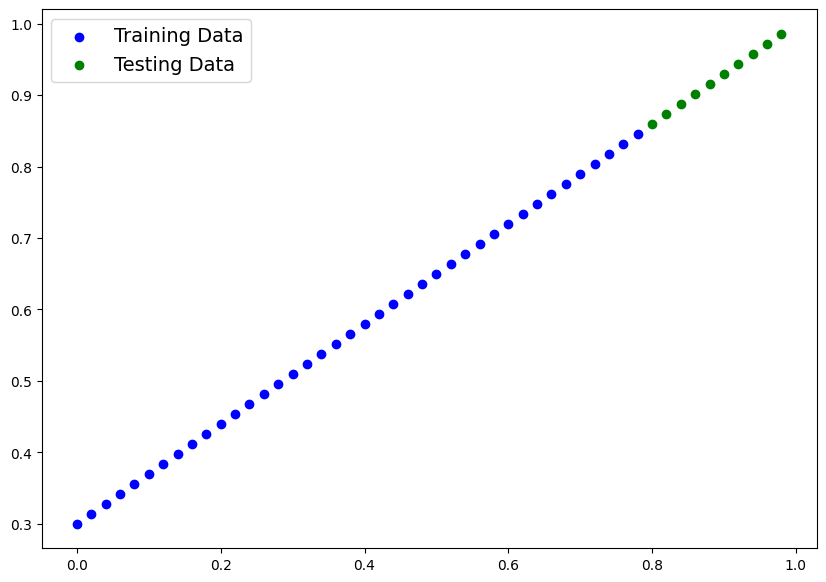

In [5]:
plot_predictions()

## 2. Buid Model



In [6]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

    self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    
  # forward method to define compution in the model
  def forward(self, x: torch.Tensor):
    return self.weights*x + self.bias # this is linear regression formula

### Pytorch Model Building essentials

PyTorch module	What does it do?
* torch.nn	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
* torch.nn.Parameter	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
* torch.nn.Module	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
* torch.optim	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
* def forward()	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### Checking the contents of our Pytorch Model

Now we have created model , let see what inside the model !!

So we can check our model parameters :

In [7]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters.
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Prediction using 'torch.inference_mode()

To check our model's predictive power, let's see how well it predicts y_test based on X_test

when we pass data through our model,it's going to run it through the forward() method

In [9]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

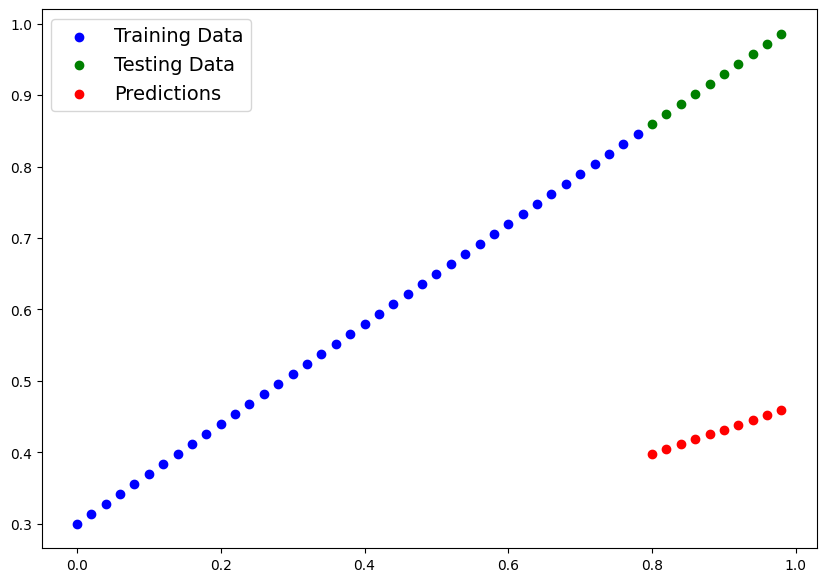

In [10]:
#ploting graph with predictions
plot_predictions(predictions = y_preds)

## 3. Train Model

The whole idea of training is for a model to move from some **unknown** parameters.


or in other words from a poor representation of the data to a better representation of the data.

one way to measure how poor or how wrong your models predictions are to use a loss function.

* Note: Loss function may also be called a cost function or criterion in different areas, for our case we are going to refer to it as a loss funvtion

Things we need to train:
* **Loss Function** : A function to measure how wrong your models' predictions are to the ideal outputs, lower is better.
* **Optimizer** : Takes into account the loss of a model and adjusts the model's parameter( e.g. weight & bias)

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [41]:
# Setup a loss function
loss_fn = nn.L1Loss()

# setup an Optimizer
Optimizer = torch.optim.SGD(params = model_0.parameters(), 
                            lr = 0.01)# lr ---> learning rate

### Building a training loop (and a testing loop) in PyTorch

A Couple of things we need in a training loop:
* Loop through the data
* Forward Pass ( thisa involves data moving through our model's `forward()` functions) to make prediction on data - also called forward propogation
* Calculate the loss(compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Loss Backward - move backwards through the netwrok to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogation**)
* Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss.(**Gradient descent**)

In [42]:
# An epoch is one loop through the data
epochs = 200

# Loop through the data
for epochs in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch Sets all parameters that requires gradients
  
  # Forward Pass
  y_pred = model_0.forward(X_train)

  # calculate loss
  loss = loss_fn(y_train, y_pred)

  #Optimizer zero grad
  Optimizer.zero_grad()

  # backward prapogation
  loss.backward()

  # step the optimizer
  Optimizer.step()

In [43]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.6951], requires_grad=True),
 Parameter containing:
 tensor([0.2993], requires_grad=True)]

In [44]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

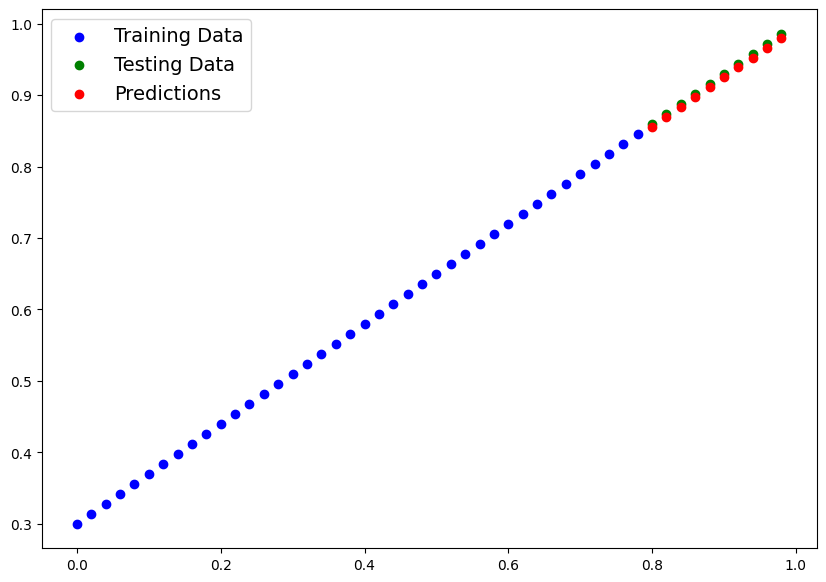

In [45]:
#ploting graph with predictions
plot_predictions(predictions = y_preds)